<a href="https://colab.research.google.com/github/melibrun/free-time/blob/main/S10_CNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MedMNIST - классификация изображений клеток

In [ ]:
!pip install medmnist

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 87 kB 3.5 MB/s 
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115943 sha256=b0d756d3df67639ea2a0301c6bf118175f6224d148e63476be26ee9dcf799275
  Stored in directory: /root/.cache/pip/wheels/8a/67/fb/2e8a12fa16661b9d5af1f654bd199366799740a85c64981226
Successfully built fire


In [ ]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import medmnist
from medmnist import INFO, Evaluator

In [ ]:
data_flag = 'bloodmnist'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [ ]:
n_channels, n_classes

(3, 8)

In [ ]:
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train',
                          transform=data_transform, 
                          download=download)
test_dataset = DataClass(split='test', 
                         transform=data_transform, 
                         download=download)

pil_dataset = DataClass(split='train',
                        download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, 
                               batch_size=BATCH_SIZE, 
                               shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, 
                                       batch_size=2*BATCH_SIZE, 
                                       shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, 
                              batch_size=2*BATCH_SIZE, 
                              shuffle=False)

  0%|          | 0/35461855 [00:00<?, ?it/s]

Using downloaded and verified file: /root/.medmnist/bloodmnist.npz
Using downloaded and verified file: /root/.medmnist/bloodmnist.npz


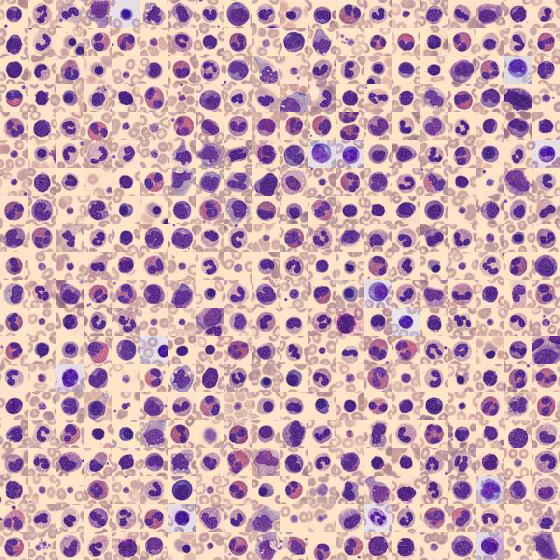

In [ ]:
train_dataset.montage(length=20)

In [ ]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset BloodMNIST (bloodmnist)
    Number of datapoints: 11959
    Root location: /root/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)', '4': 'lymphocyte', '5': 'monocyte', '6': 'neutrophil', '7': 'platelet'}
    Number of samples: {'train': 11959, 'val': 1712, 'test': 3421}
    Description: The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28.
    License: CC BY 4.0
Datas

In [ ]:
pil_dataset[0]

(<PIL.Image.Image image mode=RGB size=28x28 at 0x7F12CBC9E050>, array([7]))

In [ ]:
x, y = train_dataset[0]

In [ ]:
x.shape

torch.Size([3, 28, 28])

In [ ]:
y.shape

(1,)

In [ ]:
y

array([7])

In [ ]:
for X, y in train_loader:
    break

In [ ]:
X, y = next(iter(train_loader))

In [ ]:
X.shape

torch.Size([128, 3, 28, 28])

In [ ]:
import torch.nn.functional as F

In [ ]:
class Net(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.featurizer = nn.Sequential(
            nn.Sequential(
                nn.Conv2d(in_channels = 3, 
                        out_channels = 16,
                        kernel_size  = 3),
                nn.ReLU()
                ),
            nn.Sequential(
                 nn.Conv2d(in_channels = 16, 
                           out_channels = 32,
                           kernel_size  = 3),
                          nn.ReLU()
            ),
            nn.Sequential(
                nn.Conv2d(in_channels = 32, 
                        out_channels = 64,
                        kernel_size  = 3),
                nn.ReLU()),
            nn.Sequential(
                nn.Conv2d(in_channels = 64, 
                        out_channels = 128,
                        kernel_size  = 3),
                nn.ReLU()),
            nn.Sequential(
                nn.Conv2d(in_channels = 128, 
                        out_channels = 256,
                        kernel_size  = 3,
                        stride=2),
                nn.ReLU()),
            nn.Sequential(
                nn.Conv2d(in_channels = 256, 
                        out_channels = 512,
                        kernel_size  = 3,
                        stride=2),
                nn.ReLU()),
            nn.Sequential(
                nn.Conv2d(in_channels = 512, 
                        out_channels = 1024,
                        kernel_size  = 3,
                        stride=2),
                nn.ReLU())
            )
        self.head = nn.Sequential(
             nn.Flatten(),
             nn.Linear(1024, 8))
        

    def forward(self, x):
        x = self.featurizer(x)
        x = self.head(x)
        return x

model = Net(in_channels=n_channels, num_classes=n_classes)
    
# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
    


In [ ]:
device = torch.device("cuda:0")

In [ ]:
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [ ]:
NUM_EPOCHS = 10

In [ ]:
for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0
    
    model.train()
    for inputs, targets in tqdm(train_loader):
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()

100%|██████████| 94/94 [00:04<00:00, 23.05it/s]


In [ ]:
def test(split):
    model.eval()
    y_true = torch.tensor([]).to(device)
    y_score = torch.tensor([]).to(device)
    
    data_loader = train_loader_at_eval if split == 'train' else test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
             inputs = inputs.to(device)
             targets = targets.to(device)
             outputs = model(inputs)

             if task == 'multi-label, binary-class':
                 targets = targets.to(torch.float32)
                 outputs = outputs.softmax(dim=-1)
             else:
                 targets = targets.squeeze().long()
                 outputs = outputs.softmax(dim=-1)
                 targets = targets.float().resize_(len(targets), 1)

             y_true = torch.cat((y_true, targets), 0)
             y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.cpu().numpy()
        y_score = y_score.cpu().detach().numpy()
        
        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)
    
        print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))

        
print('==> Evaluating ...')
test('train')
test('test')

==> Evaluating ...
train  auc: 0.649  acc:0.195
test  auc: 0.642  acc:0.195


# Классификация здоровых и зараженных малярией клеток

Загрузим данные с фотографиями зараженных и незараженных малярией клеток 

In [ ]:
!wget https://kodomo.fbb.msu.ru/FBB/ml/malaria_dataset.zip 

--2022-11-24 15:42:29--  https://kodomo.fbb.msu.ru/FBB/ml/malaria_dataset.zip
Resolving kodomo.fbb.msu.ru (kodomo.fbb.msu.ru)... 93.180.63.127
Connecting to kodomo.fbb.msu.ru (kodomo.fbb.msu.ru)|93.180.63.127|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 353903672 (338M) [application/zip]
Saving to: ‘malaria_dataset.zip’

malaria_dataset.zip 100%[===================>] 337.51M  4.18MB/s    in 92s     

2022-11-24 15:44:02 (3.69 MB/s) - ‘malaria_dataset.zip’ saved [353903672/353903672]



In [ ]:
!unzip malaria_dataset.zip  > /dev/null

Посмотрим на несколько наших картинок 

In [ ]:
from IPython.display import Image

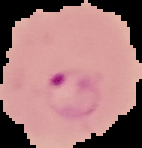

In [ ]:
Image(filename="cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_162.png")

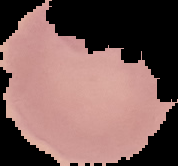

In [ ]:
Image(filename="cell_images/Uninfected/C99P60ThinF_IMG_20150918_140900_cell_66.png")

Немного видоизменим наши картинки при помощи набора преобразований. Для этого импортируем эти преобразования из pytorchvision

In [ ]:
import torch
from torchvision.transforms import Compose,  ToTensor, Resize

transform=Compose([Resize((32,32)),
                  ToTensor()])

Загрузим наш датасет 

In [ ]:
from torchvision import datasets
data = datasets.ImageFolder(root="cell_images",
                            transform=transform)

Посмотрим на размер наших данных

In [ ]:
df_size=len(data)
print('Size = {}'.format(df_size))

Size = 27558


Разобьем наши данные на обучение и тест. Какой-то явной дополнительной структуры в датасете не прослеживается, потому просто разобьем на обучение и валидацию 

In [ ]:
import numpy as np

In [ ]:
VALIDATION_SIZE=0.2
val_size =int(VALIDATION_SIZE*df_size)
train_dataset, test_dataset = torch.utils.data.random_split(data, 
                                                            [len(data) -val_size, val_size],
                                                            generator=torch.Generator().manual_seed(42)) 

In [ ]:
import torch

train_loader=torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader=torch.utils.data.DataLoader(#YOUR CODE HERE,
                                       batch_size=128)

TypeError: ignored

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.featurizer = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
                                        nn.ReLU(),
                                        nn.MaxPool2d(kernel_size=2),
                                        # Conv2d 3x3, in_c = 8, out channels = 32, 
                                        nn.ReLU(),
                                        # MaxPool 2x2
                                        )
        self.fc = nn.Sequential(nn.Flatten(),
                                # lineear layer 32 * 6 * 6 -> 64
                                nn.ReLU(),
                                nn.Linear(64, 1))
        
    def forward(self, x):
        x = self.featurizer(x)
        x = self.fc(x)
        return x
    


NameError: ignored

In [ ]:
device = torch.device("cuda")

In [ ]:
net = ConvNet().to(device)
print(net)

NameError: ignored

In [ ]:
import torch.optim as optim
import torch.nn.functional as F

criteria=nn.BCEWithLogitsLoss()
optimizer=optim.Adam(net.parameters())


Обучим модель

In [ ]:
NUM_EPOCHS=10

In [ ]:
for epoch in range(NUM_EPOCHS):
    train_loss=0
    print("%{}".format(epoch*100/NUM_EPOCHS))
    for data in train_loader:
        optimizer.zero_grad()
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.unsqueeze(1).float()
        labels = labels.to(device)
      
        outputs = net(inputs)
        loss = criteria(outputs, labels)
        train_loss += loss.detach() * labels.shape[0]
        # we must backpropagate gradient YOUR CODE HERE
        optimizer.step()
    print(train_loss / len(train_dataset))

    val_loss=0
    with torch.no_grad():
      for inputs, labels in val_loader:
          inputs = inputs.to(device)

          inputs = inputs.to(device)
          labels = labels.unsqueeze(1).float()
          labels = labels.to(device)
      
          outputs = net(inputs)
          loss = criteria(outputs, labels)
          val_loss += loss.detach() * labels.shape[0]

    print(val_loss / len(val_dataset))

print('Finished Training')

In [ ]:
print("\nValidation:")

y_true = []
y_pred = []


with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)

        y_true.append(labels.numpy())
      
        outputs = net(inputs)

        probs = torch.sigmoid(outputs)
        predicted = probs > 0.5
        y_pred.append(predicted.squeeze(1).cpu().numpy())

In [ ]:
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

In [ ]:
np.mean(y_true == y_pred)

## Правильное разбиение

А теперь внимательно прочитаем [описание](https://lhncbc.nlm.nih.gov/LHC-publications/pubs/MalariaDatasets.html) датасета и обнаружим, что вообще-то говоря, разные клетки взяты от разных пациентов. Более того, у больных пациентов были и здоровые клетки, которые тоже были добавлены в датасет

In [ ]:
!wget  https://data.lhncbc.nlm.nih.gov/public/Malaria/patientid_cellmapping_parasitized.csv
!wget  https://data.lhncbc.nlm.nih.gov/public/Malaria/patientid_cellmapping_uninfected.csv

--2022-11-24 12:17:50--  https://data.lhncbc.nlm.nih.gov/public/Malaria/patientid_cellmapping_parasitized.csv
Resolving data.lhncbc.nlm.nih.gov (data.lhncbc.nlm.nih.gov)... 108.138.94.100, 108.138.94.36, 108.138.94.24, ...
Connecting to data.lhncbc.nlm.nih.gov (data.lhncbc.nlm.nih.gov)|108.138.94.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 761124 (743K) [text/csv]
Saving to: ‘patientid_cellmapping_parasitized.csv’

patientid_cellmappi 100%[===================>] 743.29K  --.-KB/s    in 0.06s   

2022-11-24 12:17:51 (11.3 MB/s) - ‘patientid_cellmapping_parasitized.csv’ saved [761124/761124]

--2022-11-24 12:17:51--  https://data.lhncbc.nlm.nih.gov/public/Malaria/patientid_cellmapping_uninfected.csv
Resolving data.lhncbc.nlm.nih.gov (data.lhncbc.nlm.nih.gov)... 108.138.94.100, 108.138.94.36, 108.138.94.24, ...
Connecting to data.lhncbc.nlm.nih.gov (data.lhncbc.nlm.nih.gov)|108.138.94.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Le

In [ ]:
infected_images = {}

with open("patientid_cellmapping_parasitized.csv") as inp:
    for line in inp:
        name, images = line.strip().split(",", 1)
        name = name.strip()
        images = images.replace("[", "").replace("]", "").split(",")
        images = [x.strip().replace("'", "") for x in images]
        images = [x for x in images if x]

        infected_images[name] = images

In [ ]:
uninfected_images = {}
with open("patientid_cellmapping_uninfected.csv") as inp:
    for line in inp:
        name, images = line.strip().split(",", 1)
        name = name.strip()
        images = images.replace("[", "").replace("]", "").split(",")
        images = [x.strip().replace("'", "") for x in images]
        images = [x for x in images if x]

        uninfected_images[name] = images

In [ ]:
infected = list(infected_images.keys())

Поделим больных так, чтобы в трейн попало порядка 80% фотографий больных клеток

In [ ]:
infected_train = []
count_train = 0
infected_val = []
count_val = 0

for inf in infected:
    if  count_val * 4 > count_train :
        infected_train.append(inf)
        count_train += len(infected_images[inf])
    else:
        infected_val.append(inf)
        count_val += len(infected_images[inf])

In [ ]:
count_val, count_train

In [ ]:
count_val / (count_train + count_val)

In [ ]:
len(infected_train), len(infected_val)

Поделим аналогично здоровых

In [ ]:
uninfected = list(set(uninfected_images.keys()) - set(infected))

Учтем, что у больных тоже были здоровые эритроциты

In [ ]:
uninfected_train = []
count_train = sum( len(uninfected_images[inf]) for inf in infected_train)
uninfected_val = []
count_val = sum( len(uninfected_images[inf]) for inf in infected_val)

for uninf in uninfected:
    if  count_val * 4 > count_train :
        uninfected_train.append(uninf)
        count_train += len(uninfected_images[uninf])
    else:
        uninfected_val.append(uninf)
        count_val+= len(uninfected_images[uninf])

In [ ]:
count_val, count_train

In [ ]:
count_val / (count_train + count_val)

In [ ]:
len(uninfected_train), len(uninfected_val)

Теперь сделаем два датасета - для обучения и тестирования

In [ ]:
import os
import shutil
try:
  os.mkdir("train")
except FileExistsError:
  pass
try:
  os.mkdir("train/infected")
except FileExistsError:
  pass

for inf in infected_train:
    for img in infected_images[inf]:
        prev_path = os.path.join("cell_images/Parasitized", img)
        cur_path = os.path.join("train/infected", img)
        shutil.copy(prev_path, cur_path)
try:
  os.mkdir("train/uninfected")
except FileExistsError:
  pass
for inf in infected_train:
    for img in uninfected_images[inf]:
        prev_path = os.path.join("cell_images/Uninfected", img)
        cur_path = os.path.join("train/uninfected", img)
        shutil.copy(prev_path, cur_path)  
for inf in uninfected_train:
    for img in uninfected_images[inf]:
        prev_path = os.path.join("cell_images/Uninfected", img)
        cur_path = os.path.join("train/uninfected", img)
        shutil.copy(prev_path, cur_path)      

In [ ]:
!ls train/uninfected | wc -l
!ls train/infected | wc -l

In [ ]:
import os
import shutil
try:
  os.mkdir("val")
except FileExistsError:
  pass
try:
  os.mkdir("val/infected")
except FileExistsError:
  pass

for inf in infected_val:
    for img in infected_images[inf]:
        prev_path = os.path.join("cell_images/Parasitized", img)
        cur_path = os.path.join("val/infected", img)
        shutil.copy(prev_path, cur_path)
  
try:
  os.mkdir("val/uninfected")
except FileExistsError:
  pass
for inf in infected_val:
    for img in uninfected_images[inf]:
        prev_path = os.path.join("cell_images/Uninfected", img)
        cur_path = os.path.join("val/uninfected", img)
        shutil.copy(prev_path, cur_path)  
for inf in uninfected_val:
    for img in uninfected_images[inf]:
        prev_path = os.path.join("cell_images/Uninfected", img)
        cur_path = os.path.join("val/uninfected", img)
        shutil.copy(prev_path, cur_path)      

In [ ]:
!ls val/uninfected | wc -l
!ls val/infected | wc -l

Теперь загрузим эти датасеты 

In [ ]:
from torchvision.datasets import ImageFolder

In [ ]:
train_dataset = ImageFolder('train', transform=transform)
val_dataset = ImageFolder('val', transform=transform)

In [ ]:
assert train_dataset.class_to_idx == val_dataset.class_to_idx


In [ ]:
train_loader=torch.utils.data.DataLoader(#YOUR CODE HERE,
                                         batch_size=128,
                                         shuffle=True)

val_loader=torch.utils.data.DataLoader(#YOUR CODE HERE,
                                       batch_size=128)

In [ ]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
device= torch.device("cuda")

In [ ]:
net = ConvNet().to(device)
print(net)
criterion=nn.BCEWithLogitsLoss()
optimizer=optim.Adam(net.parameters())
NUM_EPOCHS=6

In [ ]:
for epoch in range(NUM_EPOCHS):
    train_loss=0
    print("%{}".format(epoch*100/NUM_EPOCHS))
    for data in train_loader:
        optimizer.zero_grad()
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.unsqueeze(1).float()
        labels = labels.to(device)
      
        outputs = net(inputs)
        loss = criteria(outputs, labels)
        train_loss += loss.detach() * labels.shape[0]
        loss.backward()
        optimizer.step()
    print(train_loss / len(train_dataset))

    val_loss=0
    with torch.no_grad():
      for inputs, labels in val_loader:
          inputs = inputs.to(device)

          inputs = inputs.to(device)
          labels = labels.unsqueeze(1).float()
          labels = labels.to(device)
      
          outputs = net(inputs)
          loss = criteria(outputs, labels)
          val_loss += loss.detach() * labels.shape[0]

    print(val_loss / len(val_dataset))

print('Finished Training')

In [ ]:
print("\nValidation:")

y_true = []
y_pred = []


with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)

        y_true.append(labels.numpy())
      
        outputs = net(inputs)

        probs = torch.sigmoid(outputs)
        predicted = probs > 0.5
        y_pred.append(predicted.squeeze(1).cpu().numpy())

In [ ]:
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

In [ ]:
np.mean(y_true == y_pred)

Видим, что в этом случае применение правильного разбиение, тем не менее, не сильно влияет на оценку качества классификации (хотя разница есть)

# Классификация цветов 

Удаляем следы предыдущего занятия

In [ ]:
!rm -rf */infected
!rm -rf */uninfected


Скачаем датасет с изображениями разных цветов

In [ ]:
!wget https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz

--2022-11-23 18:33:13--  https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 344862509 (329M) [application/x-gzip]
Saving to: ‘102flowers.tgz’

102flowers.tgz      100%[===================>] 328.89M  13.8MB/s    in 25s     

2022-11-23 18:33:40 (13.0 MB/s) - ‘102flowers.tgz’ saved [344862509/344862509]



In [ ]:
!tar -xzvf 102flowers.tgz > /dev/null

In [ ]:
!ls jpg | wc -l 

8189


И скачаем разметку этого датасета 

In [ ]:
!wget https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat
!wget https://www.robots.ox.ac.uk/~vgg/data/flowers/102/setid.mat

--2022-11-23 18:33:44--  https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 502
Saving to: ‘imagelabels.mat’

imagelabels.mat     100%[===================>]     502  --.-KB/s    in 0s      

2022-11-23 18:33:45 (98.4 MB/s) - ‘imagelabels.mat’ saved [502/502]

--2022-11-23 18:33:45--  https://www.robots.ox.ac.uk/~vgg/data/flowers/102/setid.mat
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14989 (15K)
Saving to: ‘setid.mat’

setid.mat           100%[===================>]  14.64K  73.3KB/s    in 0.2s    

2022-11-23 18:33:46 (73.3 KB/s) - ‘setid.mat’ saved [14989/14989]



In [ ]:
cat2names = {"21": "fire lily", "3": "canterbury bells", "45": "bolero deep blue", "1": "pink primrose", "34": "mexican aster", "27": "prince of wales feathers", "7": "moon orchid", "16": "globe-flower", "25": "grape hyacinth", "26": "corn poppy", "79": "toad lily", "39": "siam tulip", "24": "red ginger", "67": "spring crocus", "35": "alpine sea holly", "32": "garden phlox", "10": "globe thistle", "6": "tiger lily", "93": "ball moss", "33": "love in the mist", "9": "monkshood", "102": "blackberry lily", "14": "spear thistle", "19": "balloon flower", "100": "blanket flower", "13": "king protea", "49": "oxeye daisy", "15": "yellow iris", "61": "cautleya spicata", "31": "carnation", "64": "silverbush", "68": "bearded iris", "63": "black-eyed susan", "69": "windflower", "62": "japanese anemone", "20": "giant white arum lily", "38": "great masterwort", "4": "sweet pea", "86": "tree mallow", "101": "trumpet creeper", "42": "daffodil", "22": "pincushion flower", "2": "hard-leaved pocket orchid", "54": "sunflower", "66": "osteospermum", "70": "tree poppy", "85": "desert-rose", "99": "bromelia", "87": "magnolia", "5": "english marigold", "92": "bee balm", "28": "stemless gentian", "97": "mallow", "57": "gaura", "40": "lenten rose", "47": "marigold", "59": "orange dahlia", "48": "buttercup", "55": "pelargonium", "36": "ruby-lipped cattleya", "91": "hippeastrum", "29": "artichoke", "71": "gazania", "90": "canna lily", "18": "peruvian lily", "98": "mexican petunia", "8": "bird of paradise", "30": "sweet william", "17": "purple coneflower", "52": "wild pansy", "84": "columbine", "12": "colt's foot", "11": "snapdragon", "96": "camellia", "23": "fritillary", "50": "common dandelion", "44": "poinsettia", "53": "primula", "72": "azalea", "65": "californian poppy", "80": "anthurium", "76": "morning glory", "37": "cape flower", "56": "bishop of llandaff", "60": "pink-yellow dahlia", "82": "clematis", "58": "geranium", "75": "thorn apple", "41": "barbeton daisy", "95": "bougainvillea", "43": "sword lily", "83": "hibiscus", "78": "lotus lotus", "88": "cyclamen", "94": "foxglove", "81": "frangipani", "74": "rose", "89": "watercress", "73": "water lily", "46": "wallflower", "77": "passion flower", "51": "petunia"}
cat2names = {int(x) : y for x, y in cat2names.items()}

In [ ]:
import numpy as np
import scipy.io


In [ ]:
labels = scipy.io.loadmat('imagelabels.mat')['labels'].squeeze()
split = scipy.io.loadmat('setid.mat')
train_id = split['trnid'].squeeze()
val_id = split['valid'].squeeze()
test_id = split['tstid'].squeeze()

Посмотрим, как выглядят наши изображения. Обратите внимание на то, что в датасете нумерация идет с 1, а в numpy - с 0

passion flower


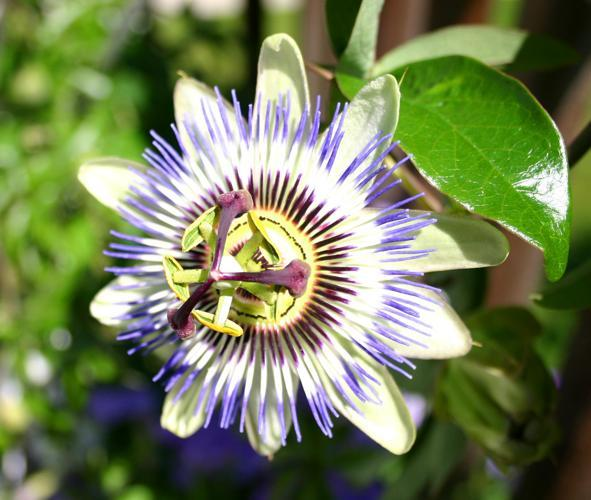

In [ ]:
from IPython.display import Image
print(cat2names[labels[0]])
Image(filename=f"jpg/image_00001.jpg")

water lily


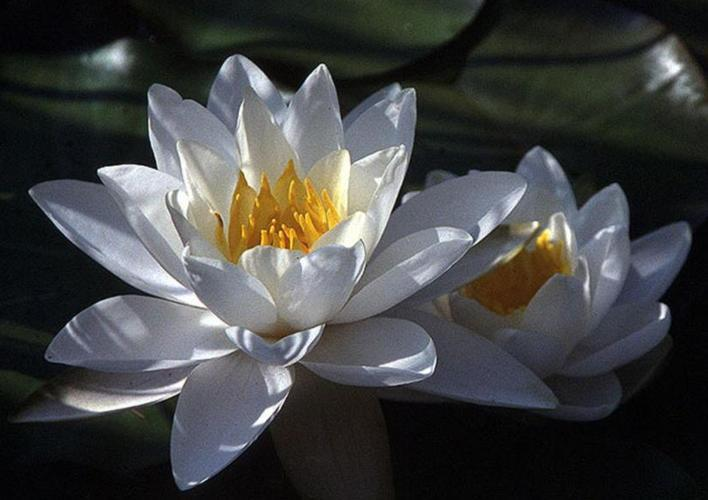

In [ ]:
from IPython.display import Image
print(cat2names[labels[251]])
Image(filename=f"jpg/image_00252.jpg")

Поправим нумерацию

In [ ]:
train_id = split['trnid'].squeeze() - 1
val_id = split['valid'].squeeze() - 1
test_id = split['tstid'].squeeze() - 1

In [ ]:
train_id.shape, val_id.shape, test_id.shape

((1020,), (1020,), (6149,))

И поменяем тестовый и обучающий датасет местами

In [ ]:
train_id, test_id = test_id, train_id

In [ ]:
import os 
import shutil


def create_datasetdir(rootdir, inds):
    try:
        os.mkdir(rootdir)
    except FileExistsError:
        pass

    class_paths = {}
    for ind in inds:
       path = f"jpg/image_0{(ind+1):04}.jpg" # 1-based indexing 
       name = os.path.basename(path)
       label = cat2names[labels[ind]]
       if not label in class_paths:
           class_paths[label] = os.path.join(rootdir, label)
           try:
               os.mkdir(class_paths[label])
           except FileExistsError:
               pass
       new_path = os.path.join(class_paths[label], name)
       shutil.copy(path, new_path)  

In [ ]:
create_datasetdir("train", train_id)
create_datasetdir("test", test_id)
create_datasetdir("val", val_id)

In [ ]:
from torchvision.datasets import ImageFolder

In [ ]:
train_dataset = ImageFolder("train")
val_dataset = ImageFolder("val")
test_dataset = ImageFolder("test")

In [ ]:
assert train_dataset.class_to_idx == val_dataset.class_to_idx
assert train_dataset.class_to_idx == test_dataset.class_to_idx

Посмотрим на размер изображений в нашем датасете

In [ ]:
train_dataset[0][0].size

(500, 667)

In [ ]:
train_dataset[1][0].size

(500, 532)

In [ ]:
from torchvision.transforms import PILToTensor

Видим, что у них разные размеры. При этом размеры отличаются несильно - потому просто будем преобразовывать изображения в train и test при помощи Resize к одному размеру. 
Если бы так размеры картинок сильно отличались, но мы так делать строго говоря не могли - где гарантия, что при преобразовании у нас расстояния на одном изображении будут похожими на расстояния на другом. А конволюции-то локальны и полагаются на это предположение

Можно решать эту проблему по-разному. 

Можно узнать, каковы минимальная ширины и высота в обучающем датасете. 

Давайте просто будем на каждом шаге обучения случайным образом обрезать вырезать из каждой картинки случайную область (500, 500)

В этом нам поможет трансформация torch.vision.transforms.RandomCrop

In [ ]:
from torchvision.transforms import Resize, Compose, ToTensor


In [ ]:
from torch.utils.data import DataLoader

In [ ]:
import torch
import torch.nn as nn

class CNN_Simple(nn.Module):
    def __init__(self):
        super().__init__()
        self.featurizer = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=16, kernel_size=7),
                                        nn.ReLU(),
                                        nn.MaxPool2d(kernel_size=2),
                                        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=7),
                                        nn.ReLU(),
                                        nn.MaxPool2d(kernel_size=2),
                                        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=7),
                                        nn.ReLU(),
                                        nn.MaxPool2d(kernel_size=2),
                                        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=7),
                                        nn.ReLU(),
                                        nn.MaxPool2d(kernel_size=2))

        self.linear = nn.Sequential(nn.Flatten(),
                                    nn.Linear(512, 256),
                                    nn.ReLU(),
                                    nn.Linear(256, len(cat2names))
                                    )
        
    def forward(self, x):
        x = self.featurizer(x)
        x = self.linear(x)
        return x

In [ ]:
train_transform = Compose([Resize(size=(128, 128)), ToTensor()])
train_dataset = ImageFolder("train", transform=train_transform)

val_transform = Compose([Resize(size=(128, 128)), ToTensor()])
val_dataset = ImageFolder("val", transform=val_transform)

In [ ]:
device = torch.device("cuda")

In [ ]:
model = # YOUR CODE HERE
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

SyntaxError: ignored

In [ ]:
train_loader = DataLoader( # YOUR CODE HERE, batch_size=512, shuffle=True)
val_loader = DataLoader( # YOUR CODE HERE, batch_size=512, shuffle=False)

In [ ]:
for epoch in range(10):
  print(epoch)
  model.train()

  train_loss = 0
  for X, y in train_loader:
      optimizer.zero_grad()
      X = X.float().to(device)
      y = y.to(device)

      pred_y = model(X)
      loss = criterion(pred_y, y)
      train_loss += loss.detach() * X.shape[0]
      loss.backward()
      optimizer.step()
  print(train_loss / len(train_dataset))
  model.eval()
  val_loss = 0
  with torch.no_grad():
      for X, y in val_loader:
          X = X.float().to(device)
          y = y.to(device)

          pred_y = model(X)
          val_loss += criterion(pred_y, y) * X.shape[0]
  print(val_loss / len(val_dataset))

Видим:

1) что учится это медленно. Для глубоких нейросетей, для большой сходимости, нужны особые приемы, которые мы разберем на следующем занятии;

2) Переобучается - качество на валидации начинает падать, а на трайне - расти. Кроме того, почти сразу видно большой гэп между качеством на трейне и валидации. Это само по себе еще не переобучение, но говорит о том, что данные в принципе отличаются и нейросеть плохо генерализует. 





С переобучением можно бороться по-разному. Будь у нас качество на валидации хоть в какой-то момент приемлимое - просто бы прерывали обучение в этот момент. Тоже обсудим в следующем занятии. 

## Transfer learning

Можно взять предобученную нейросеть, заменить в ней последние слои и обучать только их. 

In [ ]:
from torchvision import models, transforms

In [ ]:
train_transform = val_transform  = transforms.Compose([
    transforms.Resize(size=(224,  224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])


In [ ]:
train_dataset = ImageFolder("train", transform=train_transform)

val_dataset = ImageFolder("val", transform=val_transform)

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [ ]:
model  = models.resnet152(pretrained=True)
set_parameter_requires_grad(model, True)
model.fc = nn.Linear(2048, out_features=len(cat2names))

In [ ]:
model = model.to(device)
optimizer = torch.optim.Adam(model.fc.parameters())
criterion = nn.CrossEntropyLoss()
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)

In [ ]:
for epoch in range(10):
  print(epoch)
  model.train()

  train_loss = 0
  for X, y in train_loader:
      optimizer.zero_grad()
      X = X.float().to(device)
      y = y.to(device)

      # YOUR CODE HERE
      # PASS X to model and get prediction 
      loss = criterion(pred_y, y)
      train_loss += loss.detach() * X.shape[0]
      # YOUR CODE HERE
      # BACKPROP 
      # OPTIMIZER STEP
  print(train_loss / len(train_dataset))
  model.eval()
  val_loss = 0
  with torch.no_grad():
      for X, y in val_loader:
          X = X.float().to(device)
          y = y.to(device)

          pred_y = model(X)
          val_loss += criterion(pred_y, y) * X.shape[0]
  print(val_loss / len(val_dataset))

In [ ]:
model.eval()
y_pred = []
y_real = []
with torch.no_grad():
    for X, y in val_loader:
        X = X.float().to(device)
        y = y.to(device)

        pred_y = model(X)
        y_pred.append(torch.argmax(pred_y, axis=1).cpu().numpy())
        y_real.append(y.cpu().numpy())

In [ ]:
y_real = np.concatenate(y_real)
y_pred = np.concatenate(y_pred)

In [ ]:
print(f"Accuracy: {(y_real == y_pred).mean():.03f}")

Качество в разы лучше. Мораль - если есть предобученная модель от кого-то - обязательно пробуем использовать эту модель.

## *Аугментация

Можно добавить аугментации в обучающий набор - будем на каждой эпохе посылать в нейросеть не обычное изображение, а немного видоизмененное (при этом подбирая трансформации так, чтобы класс изображения не поменялся)

Таких трансформаций можно придумать много. Многие из них есть в torchvision.transforms

То, что они там есть не означает, что они подойдут для вашей задачи. Условно - изменение цвета изображения не всегда искажает класс, но в случае цветов - вполне может



In [ ]:
import PIL.Image
import matplotlib.pyplot as plt
def imshow(img, transform):
    """helper function to show data augmentation
    :param img: path of the image
    :param transform: data augmentation technique to apply"""
    
    img = PIL.Image.open(img)
    fig, ax = plt.subplots(1, 2, figsize=(15, 4))
    ax[0].set_title(f'original image {img.size}')
    ax[0].imshow(img)
    img = transform(img)
    ax[1].set_title(f'transformed image {img.size}')
    ax[1].imshow(img)

### Обрезание

In [ ]:
import torchvision.transforms as transforms
loader_transform = transforms.CenterCrop(400)
imshow('jpg/image_00001.jpg', loader_transform)

In [ ]:

loader_transform = transforms.RandomCrop(400)
imshow('jpg/image_00001.jpg', loader_transform)

### Вращения

In [ ]:
loader_transform = transforms.RandomVerticalFlip(p=1)
imshow('jpg/image_00001.jpg', loader_transform)

In [ ]:
loader_transform = transforms.RandomHorizontalFlip(p=1)
imshow('jpg/image_00001.jpg', loader_transform)

In [ ]:
loader_transform = transforms.RandomRotation( (-20, 20))
imshow('jpg/image_00001.jpg', loader_transform)

### Работа с цветом

In [ ]:
loader_transform = transforms.ColorJitter(brightness=2)
imshow('jpg/image_00001.jpg', loader_transform)

In [ ]:
loader_transform = transforms.ColorJitter(contrast=2)
imshow('jpg/image_00001.jpg', loader_transform)

In [ ]:
loader_transform = transforms.ColorJitter(saturation=5)
imshow('jpg/image_00001.jpg', loader_transform)

### Соберем эти трансформации

In [ ]:
train_transform = transforms.Compose([
    transforms.RandomChoice([transforms.CenterCrop(400), transforms.RandomCrop(400)]),
    transforms.RandomApply([transforms.RandomChoice([transforms.RandomVerticalFlip(p=1), 
                             transforms.RandomHorizontalFlip(p=1),
                             transforms.RandomRotation( (-20, 20))])],
                           p=0.7),
    transforms.RandomApply([transforms.RandomChoice([transforms.ColorJitter(brightness=2), 
                            transforms.ColorJitter(contrast=2),
                            transforms.ColorJitter(saturation=5)])]
                            ),
    Resize(size=(128, 128)),
    transforms.ToTensor()])

In [ ]:
train_dataset = ImageFolder("train", transform=train_transform)

val_transform = Compose([Resize(size=(128, 128)), ToTensor()])
val_dataset = ImageFolder("val", transform=val_transform)

In [ ]:
model = CNN_Simple().to(device)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)

In [ ]:
for epoch in range(10):
  print(epoch)
  model.train()

  train_loss = 0
  for X, y in train_loader:
      optimizer.zero_grad()
      X = X.float().to(device)
      y = y.to(device)

      pred_y = model(X)
      loss = criterion(pred_y, y)
      train_loss += loss.detach() * X.shape[0]
      loss.backward()
      optimizer.step()
  print(train_loss / len(train_dataset))
  model.eval()
  val_loss = 0
  with torch.no_grad():
      for X, y in val_loader:
          X = X.float().to(device)
          y = y.to(device)

          pred_y = model(X)
          val_loss += criterion(pred_y, y) * X.shape[0]
  print(val_loss / len(val_dataset))

Посмотрим, какомуу качеств соответствует полученный лосс. Посчитаем просто accuracy

In [ ]:
test_dataset = ImageFolder("test", transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [ ]:
model.eval()
y_pred = []
y_real = []
with torch.no_grad():
    for X, y in test_loader:
        X = X.float().to(device)
        y = y.to(device)

        pred_y = model(X)
        y_pred.append(torch.argmax(pred_y, axis=1).cpu().numpy())
        y_real.append(y.cpu().numpy())

In [ ]:
y_real = np.concatenate(y_real)
y_pred = np.concatenate(y_pred)

In [ ]:
print(f"Accuracy: {(y_real == y_pred).mean():.03f}")

Это, конечно, лучше случайного угадывания для 102 классов, но явно не сильно. 

А как сделать лучше? 

## *Self-supervised pretrained 

Также можно использовать модели, обученные в self-supervised режиме. Иногда они дают результаты лучше, чем supervised-модели

In [ ]:

!pip install lightning-bolts

In [ ]:
from pl_bolts.models.self_supervised import SimCLR

# load resnet50 pretrained using SimCLR on imagenet
weight_path = 'https://pl-bolts-weights.s3.us-east-2.amazonaws.com/simclr/bolts_simclr_imagenet/simclr_imagenet.ckpt'
simclr = SimCLR.load_from_checkpoint(weight_path, strict=False)

simclr_resnet50 = simclr.encoder
simclr_resnet50 = simclr_resnet50.eval()

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.featurizer = simclr_resnet50
        set_parameter_requires_grad(self.featurizer, True)
        self.fc = nn.Linear(2048, len(cat2names))
    def forward(self, x):
        x = self.featurizer(x)
        x = x[0] # featurizer returns list
        x = self.fc(x)
        return x

In [ ]:
model = Model().to(device)
optimizer = torch.optim.Adam(model.fc.parameters())
criterion = nn.CrossEntropyLoss()
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)

In [ ]:
for epoch in range(10):
  print(epoch)
  model.train()

  train_loss = 0
  for X, y in train_loader:
      optimizer.zero_grad()
      X = X.float().to(device)
      y = y.to(device)

      pred_y = model(X)
      loss = criterion(pred_y, y)
      train_loss += loss.detach() * X.shape[0]
      loss.backward()
      optimizer.step()
  print(train_loss / len(train_dataset))
  model.eval()
  val_loss = 0
  with torch.no_grad():
      for X, y in val_loader:
          X = X.float().to(device)
          y = y.to(device)

          pred_y = model(X)
          val_loss += criterion(pred_y, y) * X.shape[0]
  print(val_loss / len(val_dataset))

In [ ]:
model.eval()
y_pred = []
y_real = []
with torch.no_grad():
    for X, y in val_loader:
        X = X.float().to(device)
        y = y.to(device)

        pred_y = model(X)
        y_pred.append(torch.argmax(pred_y, axis=1).cpu().numpy())
        y_real.append(y.cpu().numpy())

In [ ]:
y_real = np.concatenate(y_real)
y_pred = np.concatenate(y_pred)

In [ ]:
print(f"Accuracy: {(y_real == y_pred).mean():.03f}")

Но не в этот раз(

Строго говоря - мы не использовали полностью все преимущества self-supervised подхода (разберем позже). Конкретно - можно дообучать загруженную модель на ВСЕМ нашем датасете (не передавая метки классов), а уже затем тренировать классификатор. 

Data leakage при этом не произойдет

# *Регрессия на последовательностях

Прочтите [статью](https://towardsdatascience.com/modeling-dna-sequences-with-pytorch-de28b0a05036) на Medium. Создайте модель на основе представленной в статье, способную осуществлять предсказание с качеством $R^2 \ge 0.9999$.

# *Классификация последовательностей 

Нейросеть будет учиться с текущими настройками медленно. Учтите это. Задание можно будет сделать дома 

Скачаем файл с последовательностями, с которыми связывается (или не связывается) транскрипционный фактор  ANDR 


In [ ]:
!wget https://kodomo.fbb.msu.ru/FBB/year_20/ml/ANDR_dataset.fasta 

Установим BioPython для работы с последовательностями

In [ ]:
!pip install biopython 

In [ ]:
from Bio import SeqIO 

In [ ]:
seq = next(SeqIO.parse("ANDR_dataset.fasta", 'fasta'))
seq

Видим, что в описании каждой последоательности содержится информация о том, с каким транскрипционным фактором она связывается и с какой хромосомы пришла 

In [ ]:
def parse_description(des):
    dt = {}

    name, des = des.split(None, 1)
    for record in des.split(";"):
        field, value = record.split(":")
        dt[field.strip()] = value.strip()
    return dt

In [ ]:
parse_description(seq.description)

In [ ]:
from collections import defaultdict
tf_cnt = defaultdict(int)
for seq in SeqIO.parse("ANDR_dataset.fasta", 'fasta'):
    tf = parse_description(seq.description)['tf']
    tf_cnt[tf] += 1
tf_cnt

Видим, что часть последовательностей связывается с ANDR, а другие - с другими транскрипционными факторами. Научимся отличать те, что связываются с ANDR, от остальных. 

Напишем код для работы с последовательностями 

Сначала напишем код для преобразования полученных последовательностей  в формат, с которым способны работать нейросети

In [ ]:
import torch
import torch.nn as nn 
import torch.nn.functional as F
import numpy as np

CODES = {
    "A": 0,
    "T": 3,
    "G": 1,
    "C": 2,
    'N': 4
}

INV_CODES = {value: key for key, value in CODES.items()}

COMPL = {
    'A': 'T',
    'T': 'A',
    'G': 'C',
    'C': 'G',
    'N': 'N'
}

def n2id(n):
    return CODES[n.upper()]

def id2n(i):
    return INV_CODES[i]

def n2compl(n):
    return COMPL[n.upper()]

class Seq2Tensor(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, seq):
        if isinstance(seq, torch.FloatTensor):
            return seq
        seq = [n2id(x) for x in seq]
        code = torch.from_numpy(np.array(seq))
        code = F.one_hot(code, num_classes=5)
        
        code[code[:, 4] == 1] = 0.25
        code = code[:, :4].float()
        return code

Далее напишем специальную реализацию свертки для работы с последовательностями. 

Дело в том, что в эксперименте нет информации о том, с какой именно из цепей связался транскрипционный фактор, потому надо искать мотив на обеих цепях. 
Если нейросеть выделит какой-то паттерн, тто она не должна игнорировать его наличие на одной из цепей 

In [ ]:
import math
class DNAConv2d(nn.Module):
    __constants__ = ['stride', 'padding', 'dilation', 'num_motives', 'motif_length']
    def __init__(self, 
                 num_motives,
                 motif_length,
                 stride = 1,
                 padding = 0,
                 dilation = 1,
                 bias = False):
        super().__init__()
        self.num_motives = num_motives
        self.motif_length = motif_length
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        self.weight = nn.Parameter(torch.empty(num_motives,
                                               1, 
                                               motif_length,
                                               4))
        if bias:
            self.bias = nn.Parameter(torch.empty(out_channels))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()
    
    def reset_parameters(self) -> None:
        torch.nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ =  torch.nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            torch.nn.init.uniform_(self.bias, -bound, bound)
            
    def forward(self, x):
        x1 = F.conv2d(x, self.weight, self.bias, self.stride, self.padding, self.dilation)
        rweight = torch.flip(self.weight, dims=(2,3))
        x2 = F.conv2d(x, rweight, self.bias, self.stride, self.padding, self.dilation)
        x = torch.maximum(x1, x2)
        return x 

Теперь напишем нашу нейросеть. 

Чтобы она могла предсказывать связывание с последовательностью произвольной длины - поставим в конце GlobalMaxPooling, который обсуждался в лекции

In [ ]:
class BindPredict(nn.Module):
    def __init__(self,
                 motif_length, 
                 num_motives):
        super().__init__()
        self.motif_length = motif_length
        self.num_motives = num_motives
        self.motif_finder = nn.Sequential(
            DNAConv2d(num_motives=num_motives, 
                      motif_length=motif_length),
            nn.ReLU())
        
        self.featurizer = nn.Sequential(
            nn.Conv1d(in_channels=num_motives, out_channels=32, kernel_size=11, dilation=6, stride=6),
            nn.ReLU(),
            nn.Conv1d(in_channels=32, out_channels=128, kernel_size=11, dilation=6, stride=6),
            nn.ReLU()
        )

        self.pooling = nn.AdaptiveMaxPool1d(1)
        self.linear = nn.Linear(128, 1) 


    def forward(self, x):

        x = x.unsqueeze(1)
        x = self.motif_finder(x)
        x = x.squeeze(3)
        x = self.featurizer(x)
        x = self.pooling(x)
        x = x.squeeze(2)
        x = self.linear(x)

        return x        


Проверим, что все работает 

In [ ]:
model = BindPredict(16, 32)

In [ ]:
seq_tensor = Seq2Tensor()(seq)
print(seq_tensor.shape)
seq_tensor = seq_tensor.unsqueeze(0) # create batch of size 1 with 1 channel
print(seq_tensor.shape)

In [ ]:
model(seq_tensor)

Отлично, теперь надо разбить датасет на обучение и валидацию и обучить модель. Тест опустим - в реальной задаче так делать не стоит. 

Для того, чтобы со всем этим хорошо работать, нам придется написать еще свой обработчик датасета 

In [ ]:
from torch.utils.data import Dataset
class SeqDataset(Dataset):
    def __init__(self, path, aim_tf="ANDR_HUMAN", transforms=None):
        self.path = path
        self.dataset, self.label = self.read_path(path, aim_tf)
        self.transforms = transforms
        
    @staticmethod
    def read_path(path, aim_tf):
        dataset = []
        labels = []
        for seq in SeqIO.parse(path, 'fasta'):
            dataset.append(seq)
            dscr = parse_description(seq.description)
            if dscr['tf'] == aim_tf:
                labels.append(1)
            else:
                labels.append(0)
        return dataset, labels
        
    def __getitem__(self, idx):
        seq = self.dataset[idx]
        if self.transforms:
            seq = self.transforms(seq)
        label = self.label[idx]
        
        return seq, label

    def __len__(self):
        return len(self.dataset)

In [ ]:
dataset = SeqDataset("ANDR_dataset.fasta", transforms=Seq2Tensor())

In [ ]:
dataset[0]

Разбить датасет на части можно несколькими способами. Более правильный - по хромосомам. Но сначала попробуем более простой 

In [ ]:
 val_size = int(0.2 * len(dataset))
 
 train_ds, val_ds = torch.utils.data.random_split(dataset, 
                               [len(dataset) -val_size, val_size],
                                                            generator=torch.Generator().manual_seed(42)) 

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
train_dataloader = DataLoader(train_ds, batch_size=4096, shuffle=True)
val_dataloader = DataLoader(val_ds, batch_size=4096, shuffle=False)

In [ ]:
device = torch.device("cuda")
model = BindPredict(16, 32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

criterion = nn.BCEWithLogitsLoss()

In [ ]:
EPOCH_NUM = 200

In [ ]:
for epoch in range(1, EPOCH_NUM + 1):
    print(f"Epoch {epoch}")
    model.train()
    train_loss = 0
    for ind, (X, y) in enumerate(train_dataloader):        
        print(f"Batch {ind}/{len(train_dataloader)}")
        X = X.to(device)
        y = y.float().to(device)
        pred_y = model(X).squeeze(1)

        optimizer.zero_grad()
        loss = criterion(pred_y, y)
        print(loss)
        loss.backward()
        optimizer.step()
        train_loss += loss.detach() * y.shape[0]
    print("Train", train_loss  / len(train_ds))
    val_loss = 0
    model.eval()
    with torch.no_grad():
      for ind, (X, y) in enumerate(val_dataloader):
          print(f"Batch {ind}/{len(val_dataloader)}")
          X = X.to(device)
          y = y.float().to(device)
          pred_y = model(X).squeeze(1)
          loss = criterion(pred_y, y)
          val_loss += loss * y.shape[0]
    print("Valid", val_loss / len(val_ds))

In [ ]:
ys = []
ypreds = []
y_probs = []
with torch.no_grad():
  for ind, (X, y) in enumerate(val_dataloader):
    print(f"Batch {ind}/{len(val_dataloader)}")
    X = X.to(device)
    pred_probs = torch.sigmoid(model(X).squeeze(1)) 
    pred_y = pred_probs > 0.5
    ys.append(y.numpy())
    y_probs.append(pred_probs.cpu().numpy())
    ypreds.append(pred_y.cpu().numpy())

In [ ]:
y = np.concatenate(ys)
y_pred = np.concatenate(ypreds)


print("Accuracy", (y == y_pred).mean() )

In [ ]:
from sklearn.metrics import roc_auc_score
y_prob = np.concatenate(y_probs)

print("ROC-AUC", roc_auc_score(y_true=y, y_score=y_prob))

In [ ]:
from sklearn.metrics import roc_auc_score
y_prob = np.concatenate(y_probs)

print("ROC-AUC", roc_auc_score(y_true=y, y_score=y_prob))